In [16]:
import numpy as np
import scanpy as sc
import anndata
import scvi
from scib_metrics.benchmark import Benchmarker
import torch
import scib_metrics
from lightning.pytorch.callbacks import ModelCheckpoint
import copy
%matplotlib inline
import sys
sys.path.append('..')
from functions import *
from SCVIModelCheckpoint import SCVIModelCheckpoint 

In [2]:
adata = anndata.read_h5ad(filename="../data/adataLung4.h5ad")
scvi.model.SCVI.setup_anndata(adata, layer="counts")

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [3]:
adata

AnnData object with n_obs × n_vars = 32472 × 4000
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'Scanorama', 'Unintegrated', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [4]:
def trainMetricsEpochs(vae, folder, beta, n_epochs_kl_warmup,  max_epochs, every_n = 10, log=False,logname="", early_stopping=False):
    logger = None
    if log:
        logger = TensorBoardLogger(save_dir="lightning_logs",name=logname)
    checkpoint_callback = SCVIModelCheckpoint(dirpath= f"/local/data/BachelorThesis/metaExperiments/models/{folder}/",save_last=False,filename="{epoch:d}",every_n_epochs=every_n,save_top_k=-1,scviModel=vae)
    vae.train(enable_checkpointing = True,  max_epochs = max_epochs, callbacks=[checkpoint_callback], check_val_every_n_epoch=1,logger=logger,early_stopping=early_stopping,plan_kwargs={"max_kl_weight":beta,"n_epochs_kl_warmup":n_epochs_kl_warmup})

In [5]:
def getBenchmarkResultsEpochs(adata,dir,max_epochs,n_eps=10):
    adatac = adata.copy()
    keys = []
    for i in range(int(max_epochs/n_eps)-1):
        vae = scvi.model.SCVI.load(f"{dir}epoch={n_eps*i+n_eps-1}/",adata=adata)
        keys.append(f"scVIepoch={n_eps*i+n_eps-1}")
        adatac.obsm[keys[i]] = vae.get_latent_representation()
    return runBenchmark(adatac, keys, nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans=True, silhouette_label=True,silhouette_batch=True, kbet_per_label=True)

In [6]:
def plotMetricsEpochs(bm,  max_epochs, n_eps = 10):
    benchmark_results = bm.get_results(min_max_scale=False)
    metrics = benchmark_results.keys()
    metrics_results = []
    for i in range(len(metrics)):
        metrics_results.append([])
        for j in range(int(max_epochs/n_eps)):
            metrics_results[i].append(benchmark_results[metrics[i]][f"scVIepoch={n_eps*j+n_eps-1}"])
        plt.plot(np.linspace(n_eps-1,max_epochs-1, int(max_epochs/n_eps)),metrics_results[i])
        plt.title(metrics[i])
        plt.xlabel("Epoch")
        plt.show()

In [7]:
vaeSD = scvi.model.SCVI(adata,prior_distribution='sdnormal')
vaeMG = scvi.model.SCVI(adata,prior_distribution='mixofgaus')
vaeVP = scvi.model.SCVI(adata,prior_distribution='vamp')
vaeNF = scvi.model.SCVI(adata,prior_distribution='normalflow',prior_kwargs={"num_layers":8})

In [9]:
trainMetricsEpochs(vaeSD, "MetEp_SD", 5, 200, 300, every_n=10, log=True, logname="MetEps300SD")
bmSD = getBenchmarkResultsEpochs(adata,"models/MetEp_SD/",300,10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/300:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch 300/300: 100%|██████████| 300/300 [08:23<00:00,  1.57s/it, v_num=1, train_loss_step=880, train_loss_epoch=928]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [08:23<00:00,  1.68s/it, v_num=1, train_loss_step=880, train_loss_epoch=928]
INFO     No backup URL provided for missing file models/MetEp_SD/epoch=4/model.pt                                  


type: Failed to load model file at models/MetEp_SD/epoch=4/model.pt. If attempting to load a saved model from <v0.15.0, please use the util function `convert_legacy_save` to convert to an updated format.

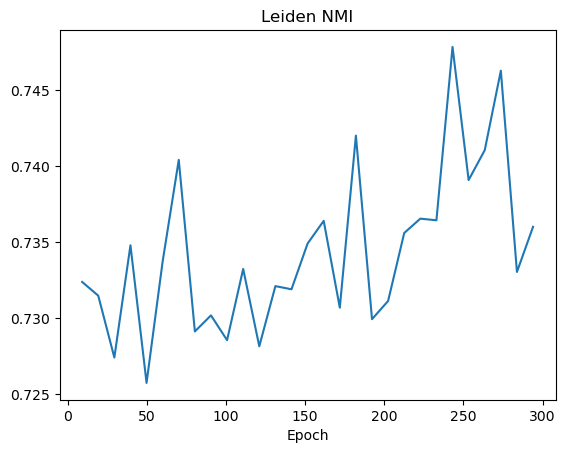

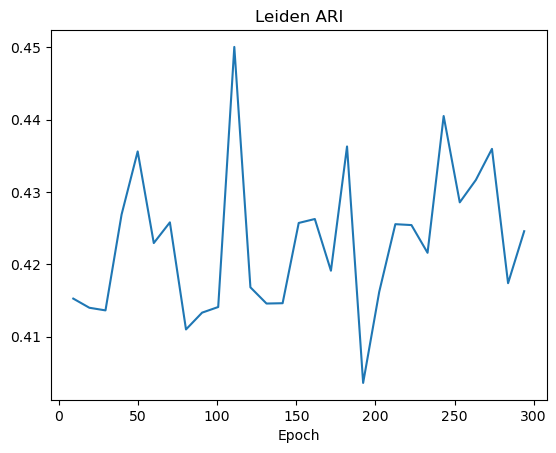

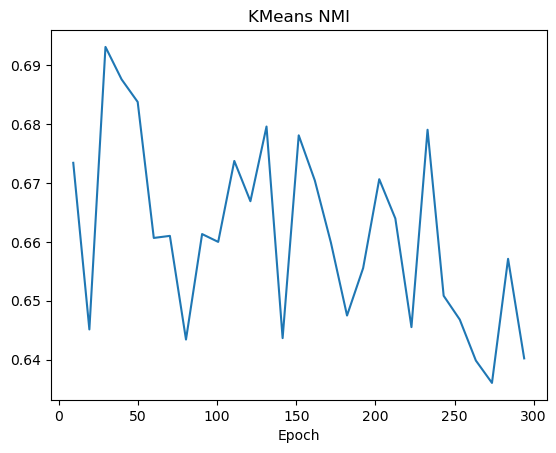

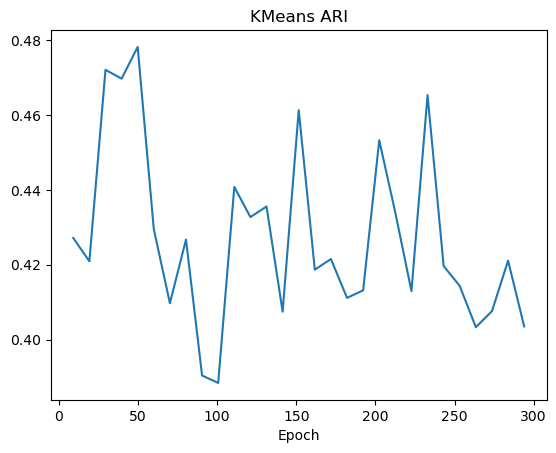

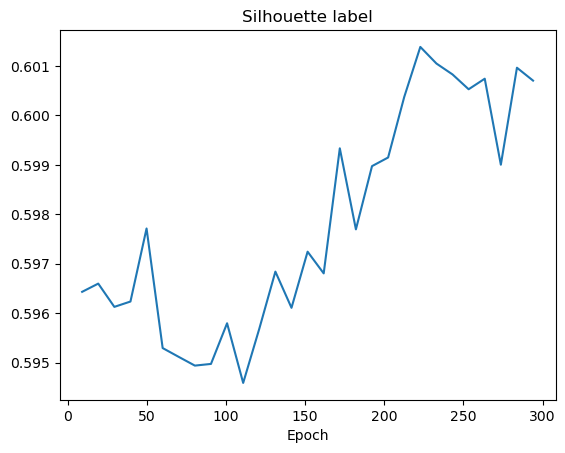

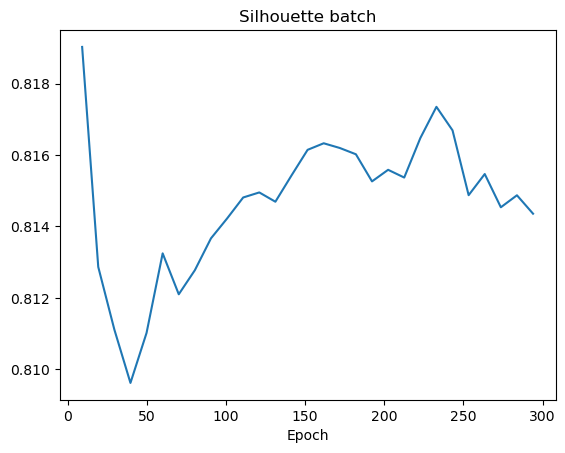

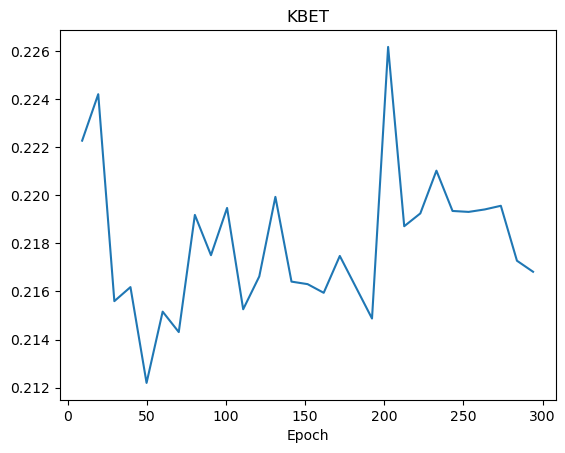

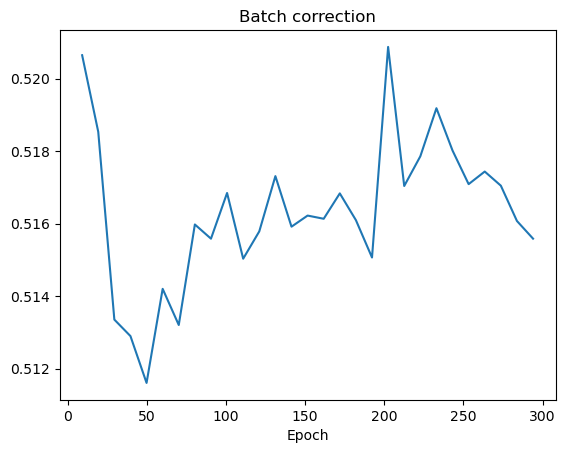

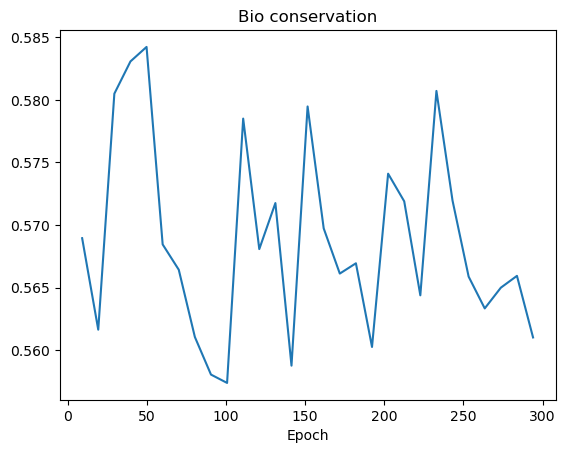

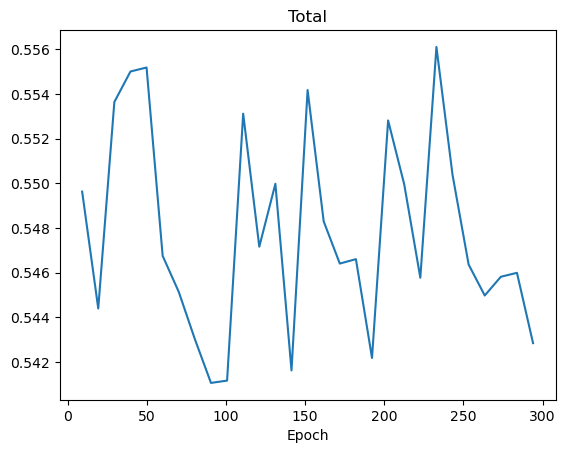

In [18]:
plotMetricsEpochs(bmSD,295,10)

In [13]:
trainMetricsEpochs(vaeMG, "MetEp_MG", 5, 200, 300, every_n=10, log=True, logname="MetEps300MG")
bmMG = getBenchmarkResultsEpochs(adata,"models/MetEp_MG/",300,10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/MetEps300MG


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [10:14<00:00,  2.06s/it, v_num=0, train_loss_step=940, train_loss_epoch=918]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [10:14<00:00,  2.05s/it, v_num=0, train_loss_step=940, train_loss_epoch=918]
INFO     File models/MetEp_MG/epoch=9/model.pt already downloaded                                                  
INFO     File models/MetEp_MG/epoch=19/model.pt already downloaded                                                 
INFO     File models/MetEp_MG/epoch=29/model.pt already downloaded                                                 
INFO     File models/MetEp_MG/epoch=39/model.pt already downloaded                                                 
INFO     File models/MetEp_MG/epoch=49/model.pt already downloaded                                                 
INFO     File models/MetEp_MG/epoch=59/model.pt already downloaded                                                 
INFO     File models/MetEp_MG/epoch=69/model.pt already downloaded                                                 


KeyboardInterrupt: 

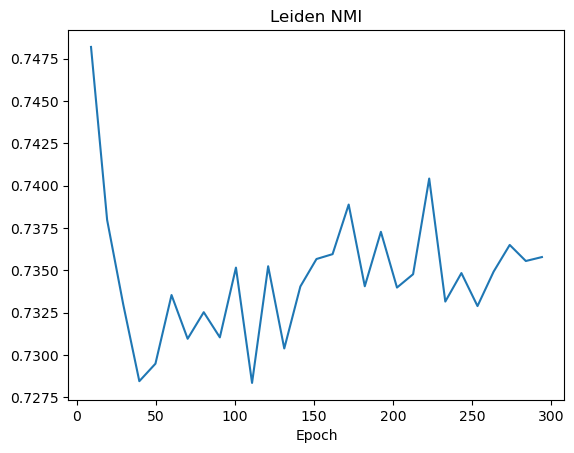

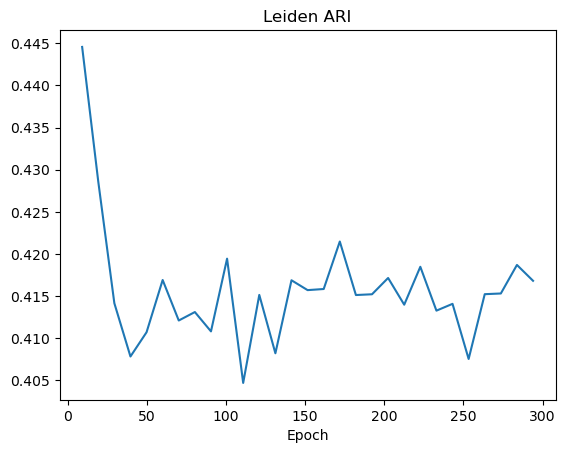

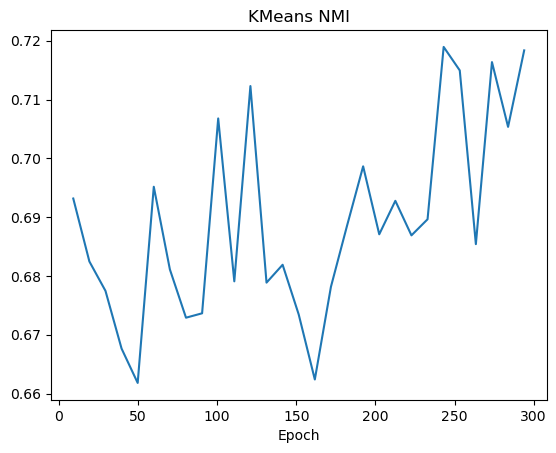

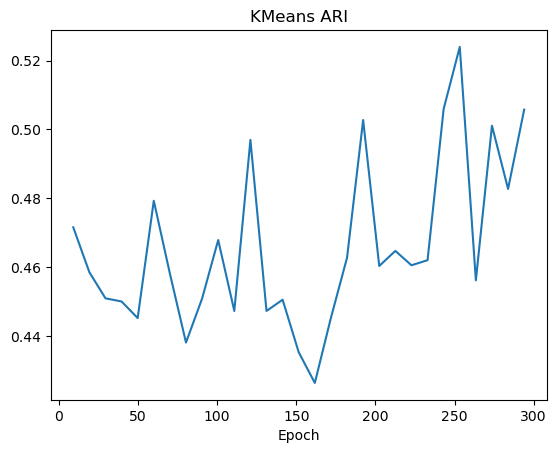

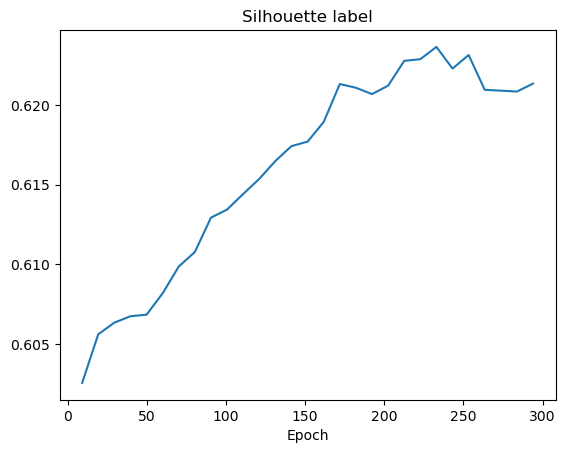

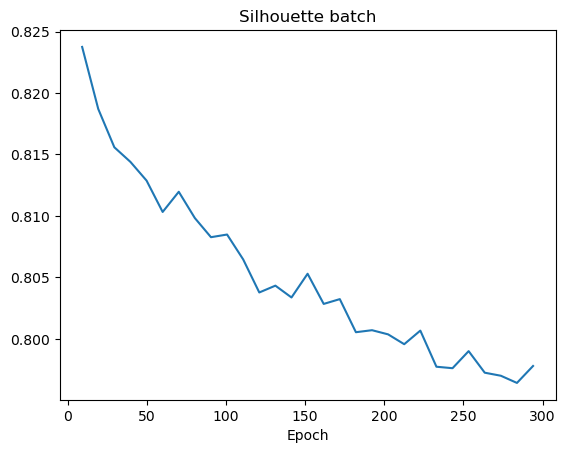

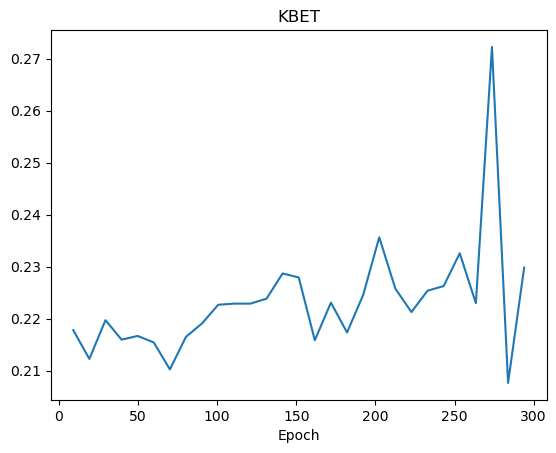

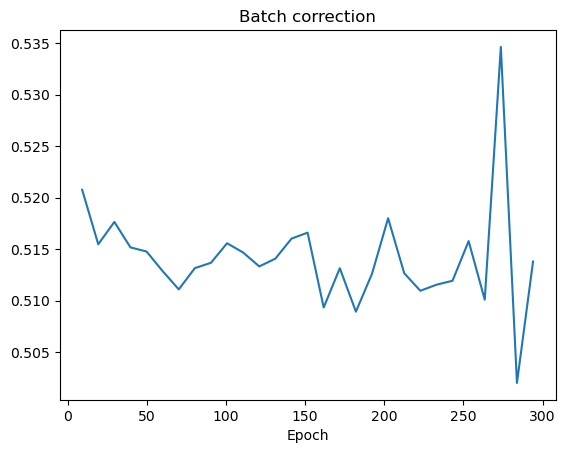

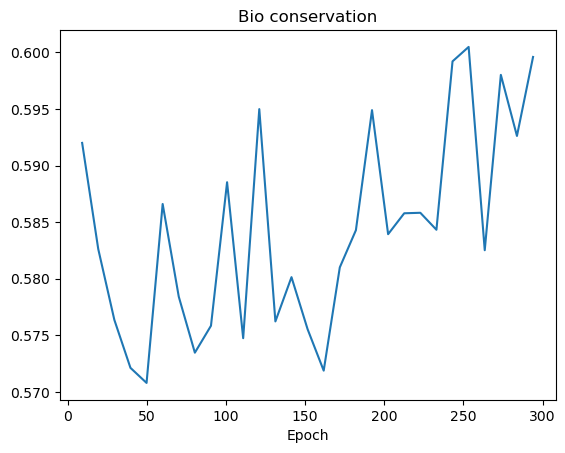

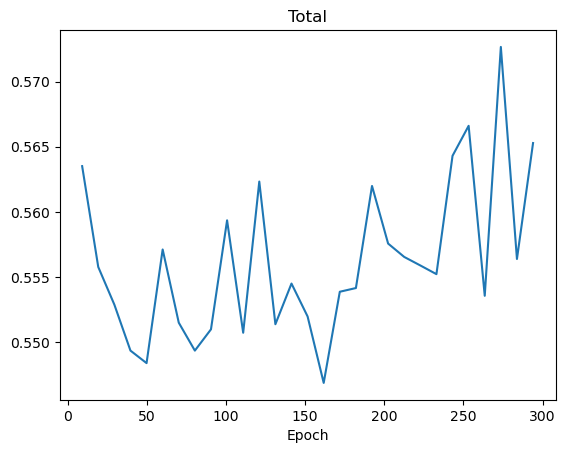

In [20]:
plotMetricsEpochs(bmMG,295,10)

In [21]:
trainMetricsEpochs(vaeVP, "MetEp_VP", 5, 200, 300, every_n=10, log=True, logname="MetEps300VP")
bmVP = getBenchmarkResultsEpochs(adata,"models/MetEp_VP/",300,10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/MetEps300VP
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [11:08<00:00,  2.16s/it, v_num=0, train_loss_step=927, train_loss_epoch=917]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [11:08<00:00,  2.23s/it, v_num=0, train_loss_step=927, train_loss_epoch=917]
INFO     File models/MetEp_VP/epoch=9/model.pt already downloaded                                                  
INFO     File models/MetEp_VP/epoch=19/model.pt already downloaded                                                 
INFO     File models/MetEp_VP/epoch=29/model.pt already downloaded                                                 
INFO     File models/MetEp_VP/epoch=39/model.pt already downloaded                                                 
INFO     File models/MetEp_VP/epoch=49/model.pt already downloaded                                                 
INFO     File models/MetEp_VP/epoch=59/model.pt already downloaded                                                 
INFO     File models/MetEp_VP/epoch=69/model.pt already downloaded                                                 
INFO     File models/MetEp_VP/epoch=79/model.pt already downloaded     

Embeddings: 100%|██████████| 29/29 [10:52<00:00, 22.51s/it]


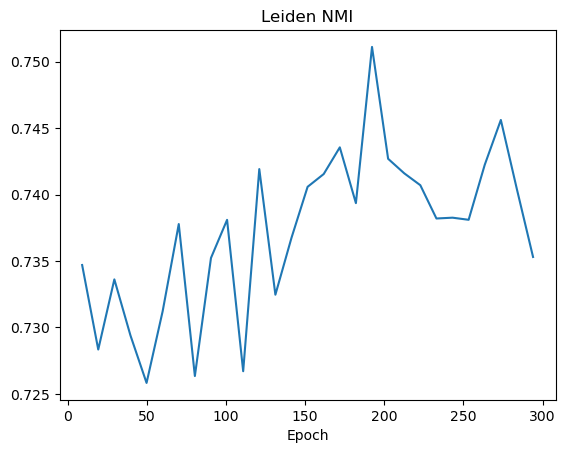

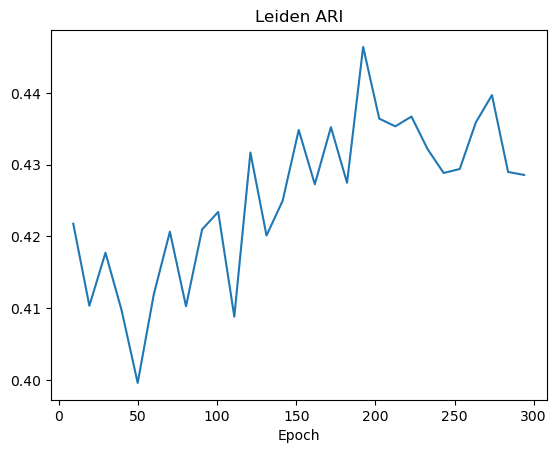

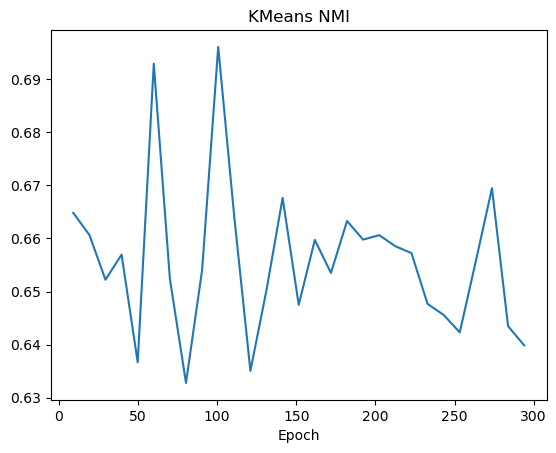

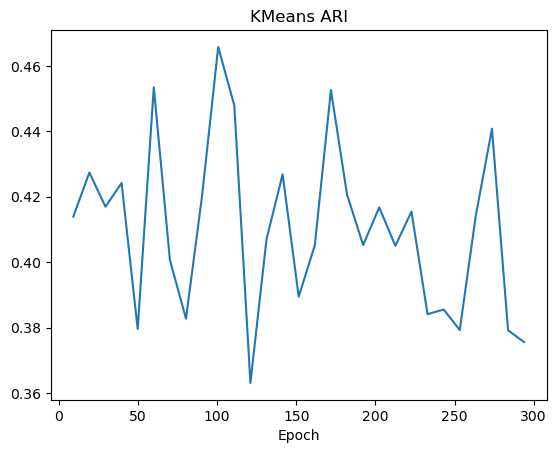

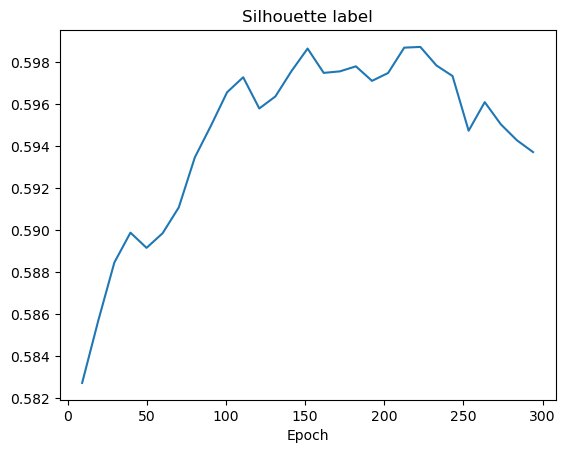

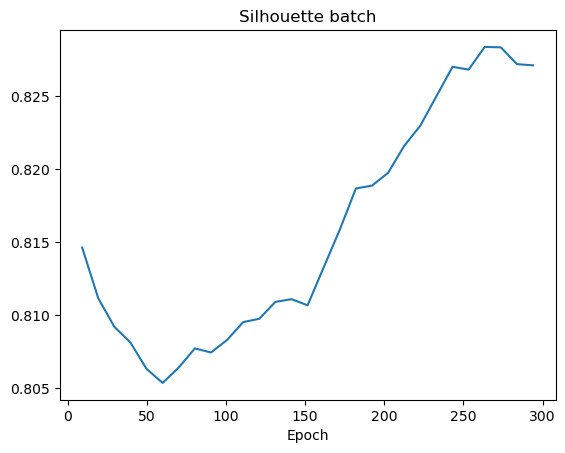

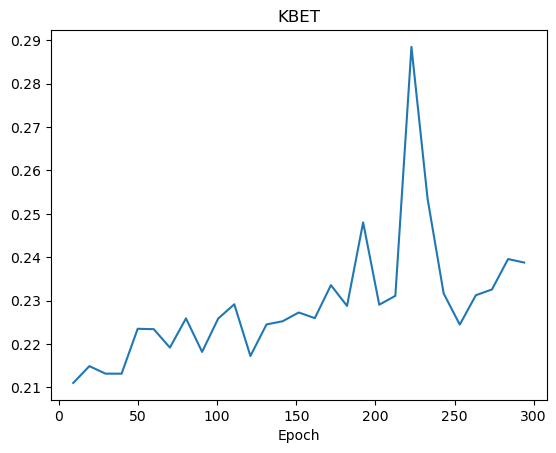

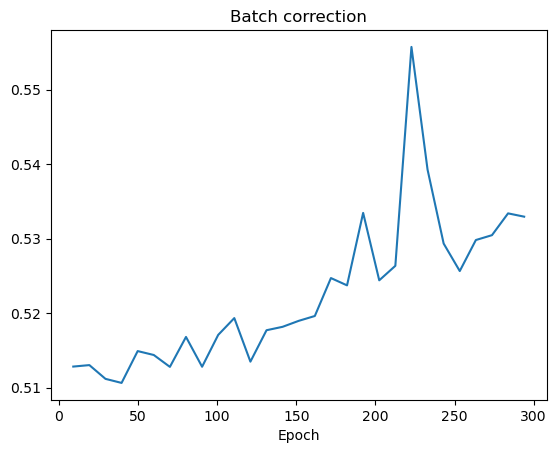

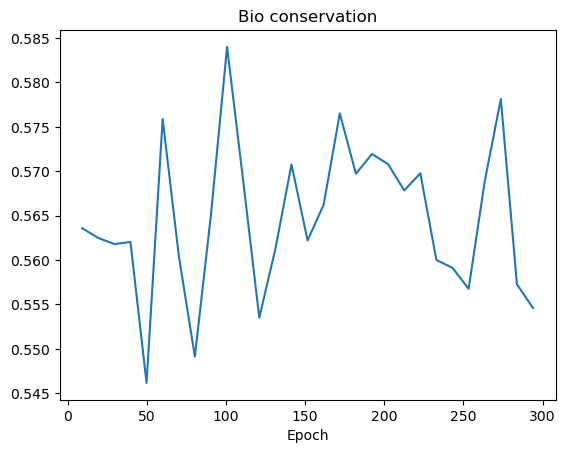

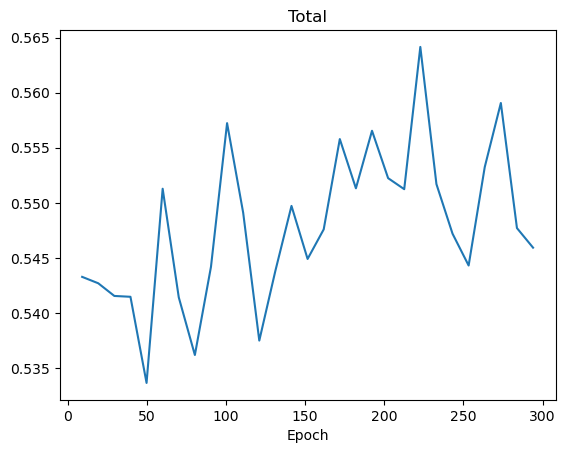

In [22]:
plotMetricsEpochs(bmVP,295,10)

In [23]:
trainMetricsEpochs(vaeNF, "MetEp_NF", 5, 200, 300, every_n=10, log=True, logname="MetEps300NF")
bmNF = getBenchmarkResultsEpochs(adata,"models/MetEp_NF/",300,10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: lightning_logs/MetEps300NF
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [17:30<00:00,  3.50s/it, v_num=0, train_loss_step=932, train_loss_epoch=920]    

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [17:30<00:00,  3.50s/it, v_num=0, train_loss_step=932, train_loss_epoch=920]
INFO     File models/MetEp_NF/epoch=9/model.pt already downloaded                                                  
INFO     File models/MetEp_NF/epoch=19/model.pt already downloaded                                                 
INFO     File models/MetEp_NF/epoch=29/model.pt already downloaded                                                 
INFO     File models/MetEp_NF/epoch=39/model.pt already downloaded                                                 
INFO     File models/MetEp_NF/epoch=49/model.pt already downloaded                                                 
INFO     File models/MetEp_NF/epoch=59/model.pt already downloaded                                                 
INFO     File models/MetEp_NF/epoch=69/model.pt already downloaded                                                 
INFO     File models/MetEp_NF/epoch=79/model.pt already downloaded     

Embeddings: 100%|██████████| 29/29 [12:58<00:00, 26.83s/it]


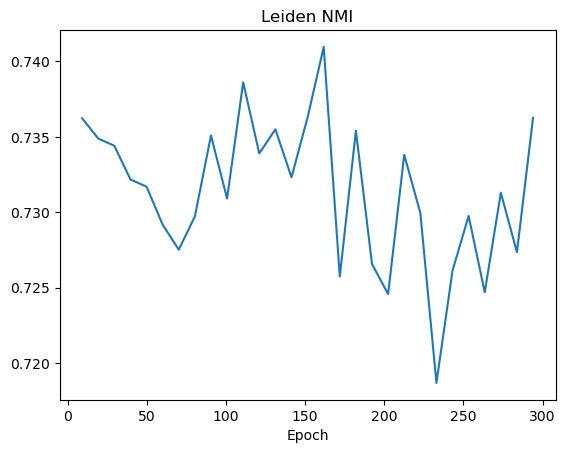

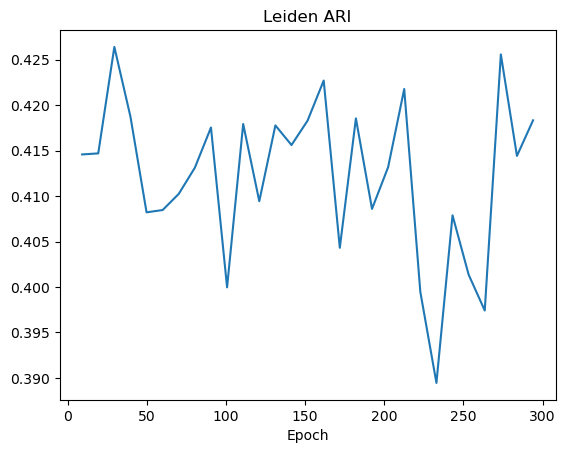

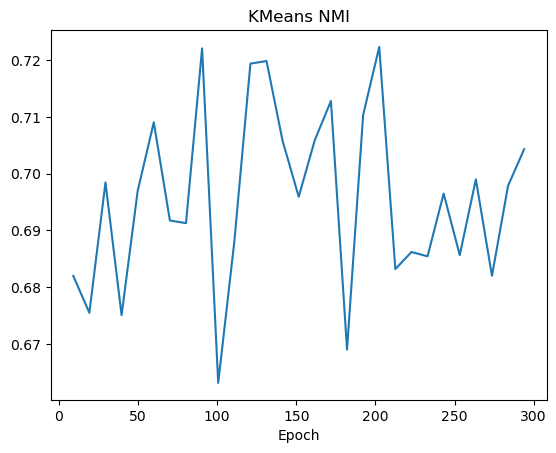

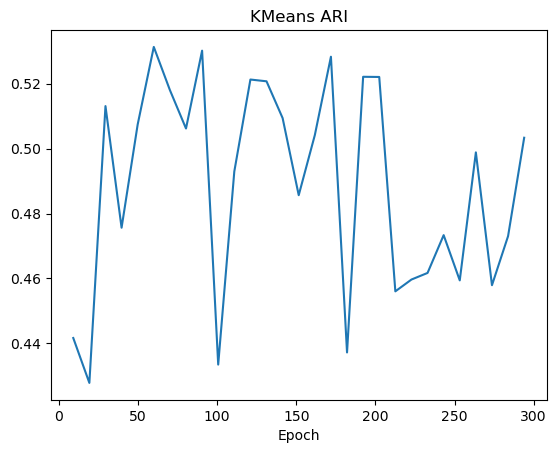

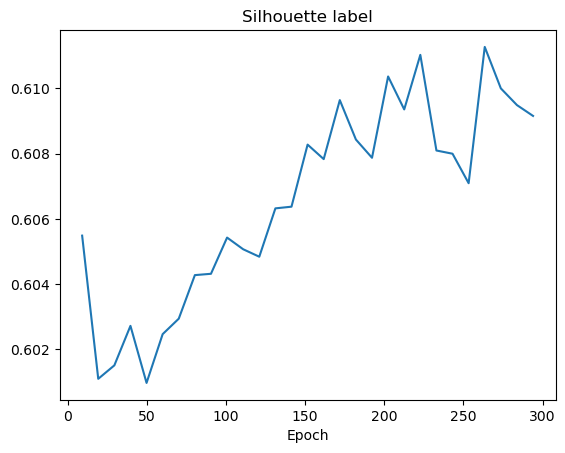

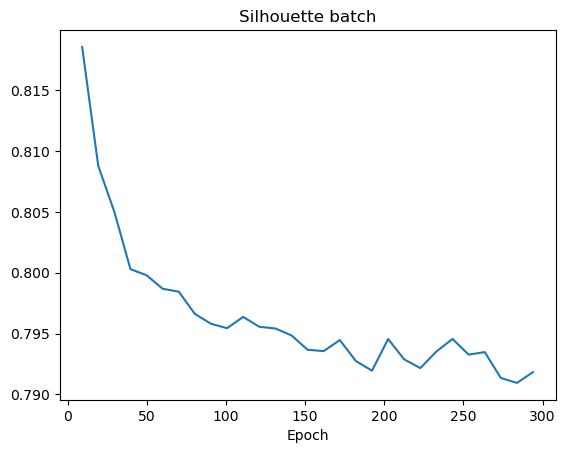

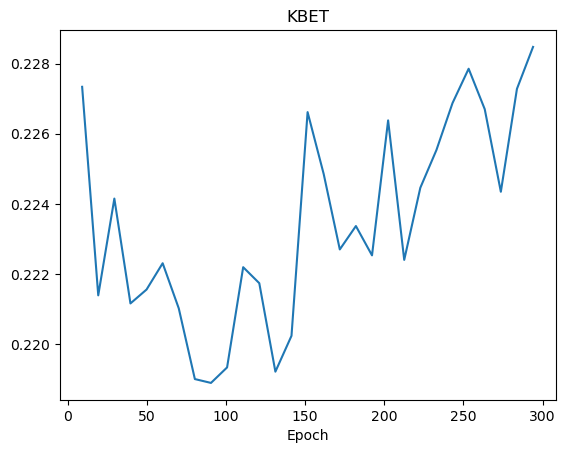

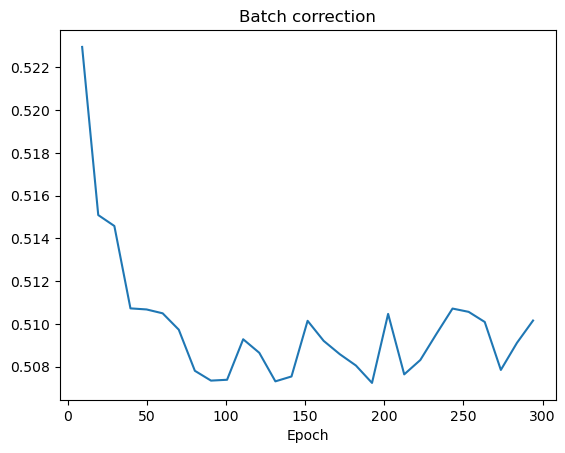

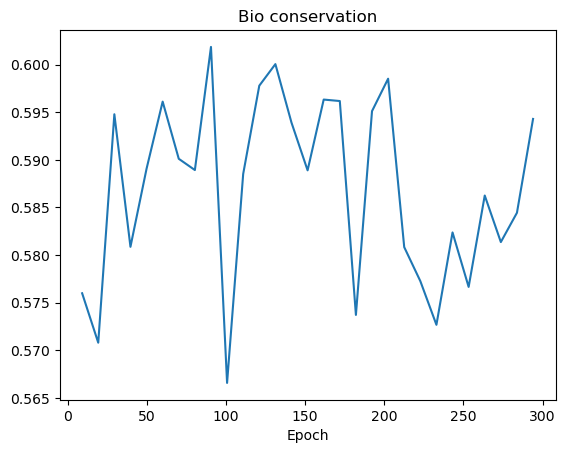

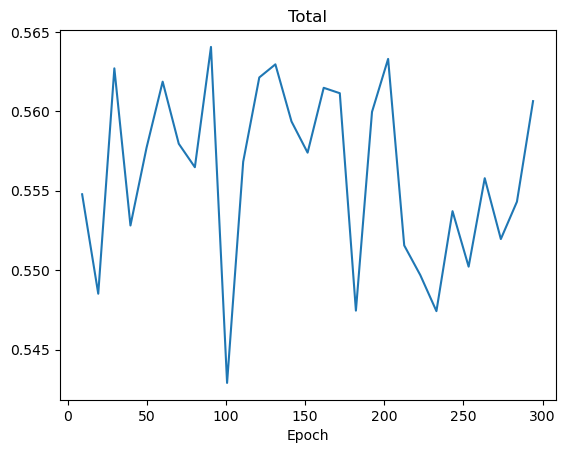

In [25]:
plotMetricsEpochs(bmNF,295,10)

In [1]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Launching TensorBoard...